In [554]:
%matplotlib inline
import seaborn as sns, numpy as np, cPickle, pandas as pd, pylab,random,cPickle, matplotlib.pyplot as plt
from os import system,listdir
from scipy.cluster.hierarchy import fcluster,linkage,cophenet
from IPython.display import display, HTML
from os.path import join,dirname,basename,isdir
global familymatching_thresh 
from sklearn import decomposition,manifold,preprocessing,metrics
from sklearn.preprocessing import scale,normalize,StandardScaler

topdir = '/cluster/zeng/research/lineage'
familymatching_thresh = 0

## Preprocess

#### un-multiplexing analysis

Performan analysis on the number of reads corresponding to each of the 8 groups with code under 
```
/cluster/zeng/code/research/lineage/index_analysis
```

In [33]:
### Summarizing the analysis output
data= []
mynames = ['endo_t1_trans','undirect_t1_trans','endo_t2_trans','undirect_t2_trans',\
          'endo_t1_fth1','undirect_t1_fth1','endo_t2_fth1','undirect_t2_fth1','undetermined']
for idx in range(len(mynames)):
    mynames[idx] = str(idx+1)+'_'+mynames[idx]
for i in range(4):
    for j in range(1):
        with open(join(topdir,'index_analysis','lane_'+str(i+1)+'_R'+str(j+1)+'_indexsummary')) as f:
            posdata = [float(x) for x in f]
        label = '_'.join(['lane'+str(i+1)])
        sumdata = float(sum(posdata))
        data += [ [posdata[idx],mynames[idx],label] for idx in range(len(posdata))]
        data += [ [posdata[idx]/sumdata,mynames[idx],label+'_pct'] for idx in range(len(posdata))]

datapd = pd.DataFrame(data,columns=['Value','Index','Label']).pivot('Index','Label','Value')
display(datapd)

Label,lane1,lane1_pct,lane2,lane2_pct,lane3,lane3_pct,lane4,lane4_pct
Index,,,,,,,,
1_endo_t1_trans,14524710,0.207710,14570768,0.203794,13383757,0.201104,13204060,0.198757
2_undirect_t1_trans,9402214,0.134456,9903809,0.138519,8755504,0.131560,8130544,0.122387
3_endo_t2_trans,5941281,0.084963,6221703,0.087020,5412467,0.081328,4434168,0.066746
4_undirect_t2_trans,237650,0.003399,282141,0.003946,235916,0.003545,207304,0.003120
5_endo_t1_fth1,2287483,0.032712,2540852,0.035538,2188699,0.032887,1869695,0.028144
6_undirect_t1_fth1,6233238,0.089138,6500198,0.090915,6164407,0.092626,5799872,0.087304
7_endo_t2_fth1,5553585,0.079419,5599672,0.078320,5246975,0.078841,5481010,0.082504
8_undirect_t2_fth1,5187264,0.074180,5155183,0.072103,5100603,0.076641,4685809,0.070534
9_undetermined,20560461,0.294024,20723293,0.289846,20063168,0.301468,22620612,0.340502


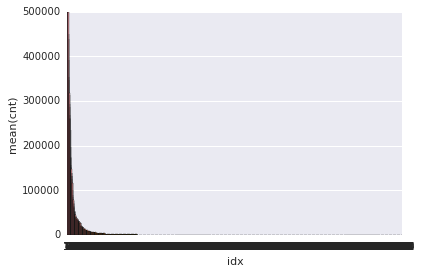

In [53]:
### Count distribution of the unmapped barcodes
with open(join(topdir,'index_analysis/unmapped.tsv')) as f:
    f.readline()
    thresh = 500000
    data = [float(x.split(',')[2]) for x in f]
    for idx in range(len(data)):
        if data[idx]> thresh:
            data[idx] = thresh
    data = pd.DataFrame([[idx,data[idx]]for idx in range(len(data))],columns=['idx','cnt'])
    sns.barplot(data=data,x='idx',y='cnt')

#### Split the reads
Split the reads into 8 groups by running
```
/cluster/zeng/code/research/lineage/splitreads/run_split_reads.sh
/cluster/zeng/code/research/lineage/splitreads/split_result/combine_6and8.sh
```

#### Run the indrop pipeline (part1)

Run 
```
python /cluster/zeng/code/research/lineage/indrops_V2/run.py 1
```
The cutoff in the second part were determined using the following elbow-point analysis

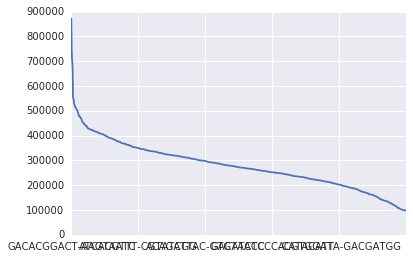

In [109]:
### Check Indrop preprocessing pipeline stats for the previous round
with open(join(t_topdir,'mESC','pre_split','barcode_read_counts.pickle'),'rb') as f:
    data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot()

,Total Reads,Frac. Valid,Valid Reads,Group
0,55683295,0.6281071908549952,34975078,1
1,36192071,0.56288356640326,20371922,2
2,22009619,0.6201914717378797,13650178,3
3,963011,0.508273529585851,489473,4
4,8886729,0.5635319812272884,5007956,5
5,24697715,0.6240795150482544,15413338,6
6,21881242,0.622645780344644,13624263,7
7,20128859,0.6609616074115279,13304403,8


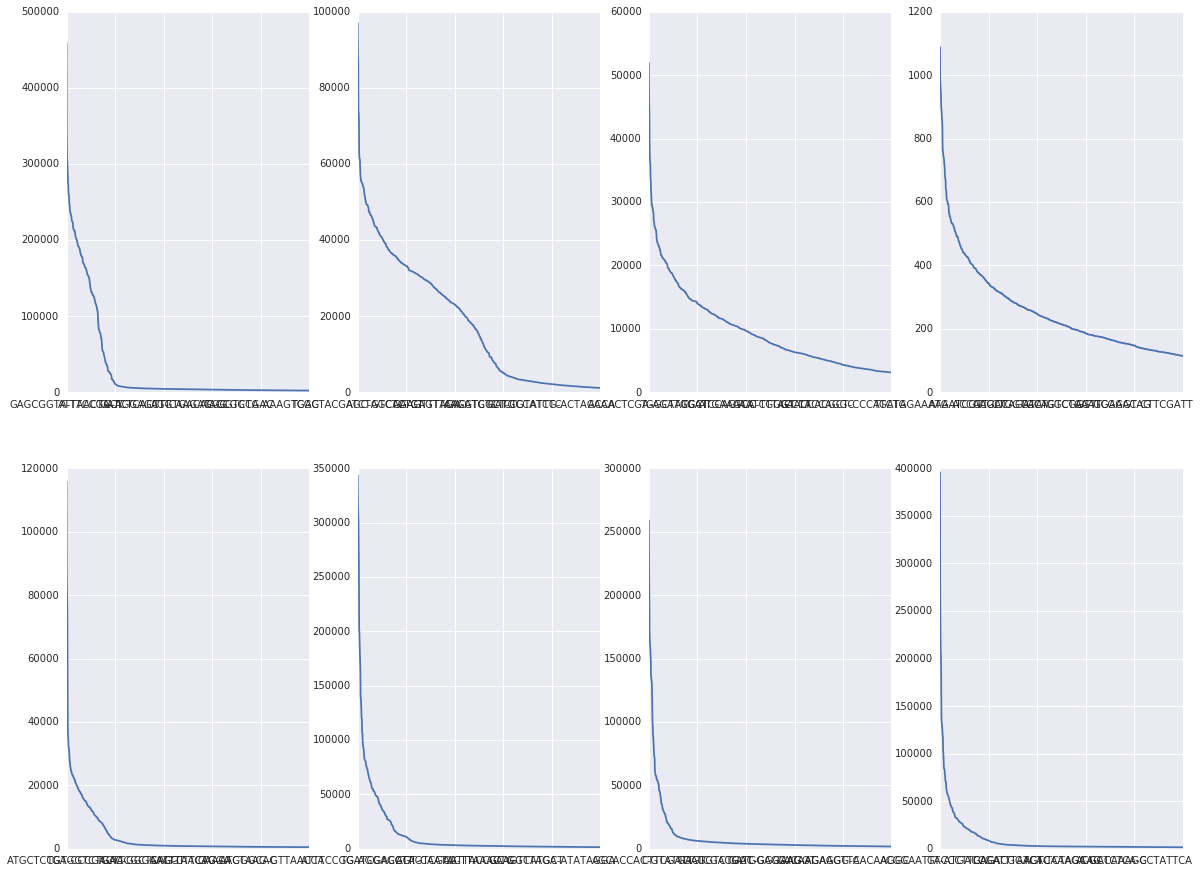

In [134]:
### Check Indrop preprocessing pipeline stats
process_stats = []
fig, axs = plt.subplots(2, 4,figsize=(20, 15))
cutoff = [10000,4000,7000,200,3000,8000,8000,6000]
for i in range(8):
    with open(join(topdir,'mESC_new'+str(i+1),'pre_split','barcode_read_counts.pickle'),'rb') as f:
        data = pd.Series(cPickle.load(f))
    data.sort_values(ascending=False)[:1000].plot(ax=axs[i/4][i%4])
    #plt.figure()
    #data.sort_values(ascending=False)[:1000].plot()
    #plt.plot(range(1000), [cutoff[i]]*1000)
    with open(join(topdir,'mESC_new'+str(i+1),'stats/filtering_metrics.yaml')) as f:
        data = [x.strip().split(': ') for x in f]
        process_stats.append([ data[-3][1],data[-2][1],data[-1][1],i+1])

display(pd.DataFrame(process_stats,columns=['Total Reads','Frac. Valid','Valid Reads','Group']))

,Total Reads,Frac. Valid,Valid Reads,Group
0,44826574,0.6406409956736823,28717741,1


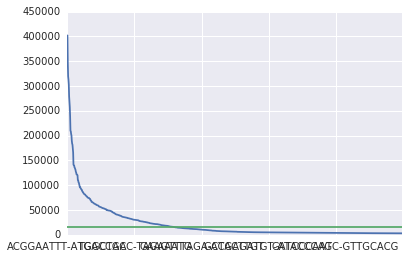

In [428]:
### Check Indrop preprocessing pipeline stats
process_stats = []
cutoff = [15000]
with open(join(topdir,'mESC_fth1_timeboth_rep2','pre_split','barcode_read_counts.pickle'),'rb') as f:
    data = pd.Series(cPickle.load(f))
plt.figure()
data.sort_values(ascending=False)[:1000].plot()
plt.plot(range(1000), [cutoff[0]]*1000)
with open(join(topdir,'mESC_fth1_timeboth_rep2','stats/filtering_metrics.yaml')) as f:
    data = [x.strip().split(': ') for x in f]
    process_stats.append([ data[-3][1],data[-2][1],data[-1][1],1])

display(pd.DataFrame(process_stats,columns=['Total Reads','Frac. Valid','Valid Reads','Group']))

#### Run the indrop pipeline (part2)

Based on the figures above, pick a reasonable read cutoff for each experiment. Change the cutoff parameter in the following script accordingly and run 
```
python /cluster/zeng/code/research/lineage/indrops_V2/run.py 2
```

In [124]:
# check the number of cells (droplets) left with the above cutoffs
display(pd.DataFrame([ len([name for name in listdir(topdir,'mESC_new' +str(i+1)+'/post_split/filtered_fastq')
            if not isdir(join(topdir,'mESC_new'\
                            +str(i+1)+'/post_split/filtered_fastq', name))]) for i in range(8)],columns=['#cell']))

,#cell
0,205
1,635
2,551
3,545
4,196
5,218
6,144
7,232


## Extract lineage barcode
Run 
```
/cluster/zeng/code/research/lineage/run.sh
```

## Barcode filtering and family analysis

In [335]:
def listdist(seqs1,seqs2,dist_thresh):
    ### If any element of seqs1 matches any element of seq2, we call it a match
    for idx1 in range(len(seqs1)):
        for idx2 in range(len(seqs2)):
            t_dist = dist(seqs1[idx1],seqs2[idx2])
            if t_dist <= dist_thresh:
                return 0
    return 1

In [458]:
def analysis2(mappingfile,family_analysis,barcode2filter,pe2readthresh):
    datacode = mappingfile.split('.raw.tsv')[0]
    
    ### Read the mapping result
    oridata = pd.read_csv(mappingfile,sep ='\t',dtype =\
                          {'barcodecnt':int,'barcode_moleculecnt':int,'readcnt':int,'moleculecnt':int})
    oridata['barcodes'] = oridata['barcodes'].apply(lambda x: np.asarray(x.split(',')))
    oridata['barcodereads_split'] = oridata['barcodereads_split'].apply(lambda x: np.asarray(map(int,x.split(','))))
    ori_barcode_coverage = pd.Series([ y for x in oridata['barcodes'] for y in x]).value_counts()
    ori_barcode_coverage.to_csv(datacode+'.bcCoverage.thresh'+str(pe2readthresh),sep='\t')
    
    ### For each cell, retain only the first two barcode with a threshold cutoff
    data = oridata.copy(deep=True)
    for index, row in data.iterrows():
        t_bc_read_cnt = row['barcodereads_split']
        topick = [x for x in np.argsort(t_bc_read_cnt)[-2:][::-1] if t_bc_read_cnt[x]>pe2readthresh]
        if len(topick) == 2:
            if t_bc_read_cnt[topick[1]] < t_bc_read_cnt[topick[0]]/2.0:
                topick = [topick[0]]
        if len(topick)>0:
            data.set_value(index,'barcodes',row['barcodes'][topick])
            data.set_value(index,'barcodereads_split',t_bc_read_cnt[topick])
            data.set_value(index,'barcode_moleculecnt',sum(t_bc_read_cnt[topick]))
            data.set_value(index,'barcodecnt',len(topick))
        else:
            data.set_value(index,'barcodes',['\\'])
    data['barcodes'] = data['barcodes'].apply(lambda x:','.join(x))
    
    barcode_coverage = pd.Series([ y for x in data['barcodes'] for y in x.split(',')]).value_counts()
    barcode_coverage.to_csv(datacode+'.bcCoverage.postfilter.thresh'+str(pe2readthresh),sep='\t')
    bi_barcode_coverage = pd.Series([ ','.join(np.sort(x.split(','))) for x in data['barcodes'] ]).value_counts()
    bi_barcode_coverage.to_csv(datacode+'.bcCoverage.postfilter.bi.thresh'+str(pe2readthresh),sep='\t')
    
    stats= [['# of reads',oridata['readcnt'].sum()],\
            ['# of transcript molecules (unique UMI)',oridata['moleculecnt'].sum()],\
            ['# of transcript molecules (unique UMI) w. bc',oridata['barcode_moleculecnt'].sum()],\
            ['# of cells',len(oridata)],\
            ['# of barcodes',len(ori_barcode_coverage)],\
            ['# of cells after processing',len(data[data['barcodes']!= '\\'])],\
            ['# of barcodes after processing',len(barcode_coverage)],\
            ['# of barcodes after processing (concat two bc)',len(bi_barcode_coverage)],\
            ]
    summary = pd.DataFrame([[x[0],x[1]] for x in stats],columns=['Item','Num'])
    
    ### Family analysis
    family_summary = family2(data[data['barcodes']!= '\\'],[datacode+'.familyanalysis-cellcentric'+\
                             '.thres'+str(pe2readthresh)+'.csv',datacode+'.familyanalysis-aggregated'+\
                             '.thres'+str(pe2readthresh)+'.csv']) if family_analysis else None
        
    return summary,family_summary

In [462]:
def reorder(x):
    t_barcodes = x['barcodes'].split(',')
    pick = np.argsort(t_barcodes)
    x['barcodes'] = ','.join([t_barcodes[y] for y in pick])
    x['barcodereads_split'] = [x['barcodereads_split'][y] for y in pick]
    return x

def family2(data,outfiles):
    num_data = len(data)
    data.index = range(num_data)
    
    cond_dist = [listdist(data.get_value(idx1,'barcodes').split(','),data.get_value(idx2,'barcodes').split(','),\
                          familymatching_thresh) for idx1 in range(num_data-1) for idx2 in range(idx1+1,num_data)]
    link = linkage(cond_dist,method='single')
    data['lineage'] = pd.Series(fcluster(link,0.5,criterion='distance')-1,index=data.index)
    data = data.sort_values(by='lineage').apply(lambda x: reorder(x),axis=1)
    data.to_csv(outfiles[0],index=False)
    
    lineage_info = []
    for name, group in data.groupby('lineage'):
        vc = group['barcodes'].value_counts()
        for idx,x in enumerate(vc):
            lineage_info.append([name,vc.index[idx],x])
                      
    pd.DataFrame(lineage_info,columns=['Lineage','Barcodes','Cnt']).to_csv(outfiles[1])
    
    stats= [['# of cells included in family analysis',num_data] ,\
            ['# of lineages',len(data['lineage'].unique())],\
            ['Size of lineages',list(data['lineage'].value_counts())]
             ]
    summary = pd.DataFrame([[x[0],x[1]] for x in stats],columns=['Item','Num'])
    return summary

In [463]:
### fth1 integrated barcodes
for t_thresh in [1,3,10]:
    allsummary = None
    allsummary_family = None
    for idx, expt in enumerate(['mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2','mESC_fth1_timeboth_rep2']):
        mappingfile = join(topdir,expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.raw.tsv')
        t_s,t_family = analysis2(mappingfile,True,[],t_thresh)
        t_s.columns = ['Item',expt]
        t_family.columns = ['Item',expt]
        allsummary = t_s if allsummary is None else allsummary.merge(t_s,on='Item')
        allsummary_family = t_family if allsummary_family is None else allsummary_family.merge(t_family,on='Item')
    combined = allsummary.append(allsummary_family)
    combined['Thresh'] = pd.Series(t_thresh,index=combined.index)
    display(combined)
    combined.to_csv(join(topdir,'fth1.stats.thresh'+str(t_thresh)+'.csv'),index=False)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2,mESC_fth1_timeboth_rep2,Thresh
0,# of reads,2998912,10967607,6146482,8027986,18220548,1
1,# of transcript molecules (unique UMI),173648,128075,135995,173619,509308,1
2,# of transcript molecules (unique UMI) w. bc,1914,72559,36020,114088,140148,1
3,# of cells,196,218,144,232,324,1
4,# of barcodes,16,385,118,308,522,1
5,# of cells after processing,122,218,144,232,324,1
6,# of barcodes after processing,4,13,7,12,13,1
7,# of barcodes after processing (concat two bc),4,17,7,17,20,1
0,# of cells included in family analysis,122,218,144,232,324,1
1,# of lineages,3,9,4,6,7,1


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2,mESC_fth1_timeboth_rep2,Thresh
0,# of reads,2998912,10967607,6146482,8027986,18220548,3
1,# of transcript molecules (unique UMI),173648,128075,135995,173619,509308,3
2,# of transcript molecules (unique UMI) w. bc,1914,72559,36020,114088,140148,3
3,# of cells,196,218,144,232,324,3
4,# of barcodes,16,385,118,308,522,3
5,# of cells after processing,57,217,143,232,324,3
6,# of barcodes after processing,2,14,7,12,13,3
7,# of barcodes after processing (concat two bc),2,18,7,17,20,3
0,# of cells included in family analysis,57,217,143,232,324,3
1,# of lineages,1,9,4,6,7,3


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2,mESC_fth1_timeboth_rep2,Thresh
0,# of reads,2998912,10967607,6146482,8027986,18220548,10
1,# of transcript molecules (unique UMI),173648,128075,135995,173619,509308,10
2,# of transcript molecules (unique UMI) w. bc,1914,72559,36020,114088,140148,10
3,# of cells,196,218,144,232,324,10
4,# of barcodes,16,385,118,308,522,10
5,# of cells after processing,8,217,143,232,324,10
6,# of barcodes after processing,2,14,7,12,13,10
7,# of barcodes after processing (concat two bc),2,18,7,17,20,10
0,# of cells included in family analysis,8,217,143,232,324,10
1,# of lineages,1,9,4,6,7,10


In [385]:
### fth1 barcodelet
for t_thresh in [1,3,10]:
    allsummary = None
    allsummary_family = None
    for expt in ['mESC_fth1_time1_rep1','mESC_fth1_time1_rep2','mESC_fth1_time2_rep1','mESC_fth1_time2_rep2']:
        mappingfile = join(topdir,expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.barcodelet')
        t_s,t_family = analysis2(mappingfile,False,[],t_thresh)
        t_s.columns = ['Item',expt]
        allsummary = t_s if allsummary is None else allsummary.merge(t_s,on='Item')
    allsummary['Thresh'] = pd.Series(t_thresh,index=allsummary.index)
    display(allsummary)
    allsummary.to_csv(join(topdir,'barcodelet.stats.thresh'+str(t_thresh)+'.csv'),index=False)

,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2,Thresh
0,# of reads,2998912,10967607,6146482,8027986,1
1,# of transcript molecules (unique UMI),173648,128075,135995,173619,1
2,# of transcript molecules (unique UMI) w. bc,296,103,228,115,1
3,# of cells,196,218,144,232,1
4,# of barcodes,77,40,67,60,1
5,# of cells after processing,63,18,37,13,1
6,# of barcodes after processing,25,12,24,6,1
7,# of barcodes after processing (concat two bc),27,11,23,6,1


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2,Thresh
0,# of reads,2998912,10967607,6146482,8027986,3
1,# of transcript molecules (unique UMI),173648,128075,135995,173619,3
2,# of transcript molecules (unique UMI) w. bc,296,103,228,115,3
3,# of cells,196,218,144,232,3
4,# of barcodes,77,40,67,60,3
5,# of cells after processing,12,1,14,0,3
6,# of barcodes after processing,8,2,5,1,3
7,# of barcodes after processing (concat two bc),8,2,5,1,3


,Item,mESC_fth1_time1_rep1,mESC_fth1_time1_rep2,mESC_fth1_time2_rep1,mESC_fth1_time2_rep2,Thresh
0,# of reads,2998912,10967607,6146482,8027986,10
1,# of transcript molecules (unique UMI),173648,128075,135995,173619,10
2,# of transcript molecules (unique UMI) w. bc,296,103,228,115,10
3,# of cells,196,218,144,232,10
4,# of barcodes,77,40,67,60,10
5,# of cells after processing,0,0,0,0,10
6,# of barcodes after processing,1,1,1,1,10
7,# of barcodes after processing (concat two bc),1,1,1,1,10


## Transcriptome analysis

#### Run the step 3 and 4 of Indrop pipeline to map the transcripts

Run 

```
    cd /cluster/zeng/code/research/lineage/indrops_V2/indrops/
    python run.py 3   (It will instruct you how to qsub the jobs output to a folder)
    python run.py 4
    
```

#### Construct a dictionary that maps droplet-cell barcode to lineage using the results from the above analysis of fth1 barcodes

In [492]:
lineage_assignment = pd.read_csv(join(topdir,'mESC_fth1_timeboth_rep2/post_split/final_lineage_assignment.csv'))

for expt in ['mESC_fth1_time1_rep2','mESC_fth1_time2_rep2']:
    cellbc2lineage = dict()
    with open(join(topdir,expt,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
        cellbc2name = cPickle.load(f)
    name2lineagebc = pd.read_csv(join(topdir,expt,'post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2.familyanalysis-cellcentric.thres10.csv'))
    for idx,key in enumerate(cellbc2name.keys()) :
        t_row = name2lineagebc[name2lineagebc['cell']==cellbc2name[key]]['barcodes']
        if len(t_row>0):
            t_barcodes = ','.join(np.sort(t_row.iloc[0].split(',')))
            t_lineage = lineage_assignment[lineage_assignment['Barcodes']==t_barcodes]['Lineage']
            if len(t_lineage) > 0:
                cellbc2lineage[key] = t_lineage.iloc[0]
                with open(join(topdir,expt,'post_split','cellbc2lineage.pkl'),'wb') as f:
                    cPickle.dump(cellbc2lineage,f)

#### Take a look the expression data

In [657]:
def mynormalizer(data):
    return StandardScaler().fit_transform(normalize(np.log10(data+0.1), axis=1, norm='l1'))

def mynormalizer2(data):
    return StandardScaler().fit_transform(normalize(data, axis=1, norm='l1'))

def loadexpr(datafile,cellmapper):
    with open(datafile) as f:
        rawdata = [x.strip().split('\t') for x in f]
    cells = rawdata[0][4:]
    data = np.asarray([map(float,x[4:]) for x in rawdata[1:]]).transpose()
    print 'data shape',data.shape

    unique_family = list(set(cellmapper.values()))
    data_norm = mynormalizer(data)

    lineagemap = []
    toanno_idx = []
    toanno_label = []
    for idx in range(len(data_norm)):
        t_key = cellmapper[cells[idx]]
        if t_key!='NA':
            lineagemap.append(t_key)
            toanno_idx.append(idx)
            toanno_label.append(t_key)
        else:
            lineagemap.append('others')
    print 'len of toanno_idx',len(toanno_idx)
    return data_norm, lineagemap, toanno_idx, toanno_label,unique_family,data

In [658]:
expr_data = dict()
for t_expt_trans in ['mESC_trans_time1_rep2','mESC_trans_time2_rep2']:
    t_expt_fth1 = t_expt_trans.replace('trans','fth1')
    with open(join(topdir,t_expt_fth1,'post_split','cellbc2lineage.pkl'),'rb') as f:
        cellbc2lineage = cPickle.load(f)
    with open(join(topdir,t_expt_trans,'pre_split/good_barcodes_with_names.pickle'),'rb') as f:
        cellbc2name = cPickle.load(f)

    t_mapper = dict()
    t_table = []
    for idx,key in enumerate(cellbc2name.keys()):
        t_lineage = cellbc2lineage[key] if key in cellbc2lineage.keys() else 'NA'
        t_mapper[cellbc2name[key]] = t_lineage
        t_table.append([cellbc2name[key],t_lineage])
    display(pd.DataFrame(t_table,columns=['name','lineage'])['lineage'].value_counts())
    expr_data[t_expt_trans] = loadexpr(join(topdir,t_expt_trans,'aggregated_counts/full_counts.txt'),t_mapper)

NA    461
6      82
7      34
8      18
3      15
1       9
5       5
0       5
4       3
2       3
Name: lineage, dtype: int64

data shape (635, 28662)
len of toanno_idx 174


NA    412
6      84
7      18
3      15
0       9
1       3
8       2
4       2
Name: lineage, dtype: int64

data shape (545, 28662)
len of toanno_idx 133


mESC_trans_time1_rep2


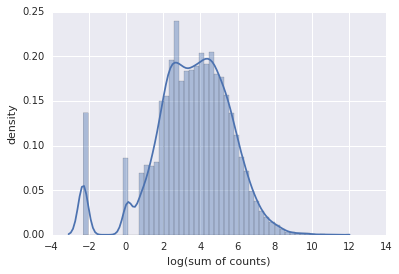

mESC_trans_time2_rep2


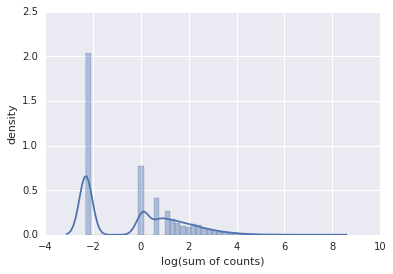

In [666]:
for t_expt_trans in ['mESC_trans_time1_rep2','mESC_trans_time2_rep2']:
    print t_expt_trans
    sns.distplot(np.log(np.sum(expr_data[t_expt_trans][-1],axis=0)+0.1))
    plt.xlabel('log(sum of counts)')
    plt.ylabel('density')
    plt.show()

#### PCA analysis

In [660]:
def oneVothers(unique_family,Y,lineagemap):
    t_data = []
    for t_idx,lineage in enumerate(unique_family):
        if lineage == 'NA':
            continue
        t_data += [[Y[idx][0],Y[idx][1],'this',lineage] if lineagemap[idx]==lineage \
                      else [Y[idx][0],Y[idx][1],'others',lineage] for idx in range(len(Y))]
    sns.lmplot(x='d1',y='d2',hue='label',col='lineage',col_wrap=3,palette ="Set1",
               data=pd.DataFrame(t_data,columns=['d1','d2','label','lineage']),fit_reg =False)
    plt.show()

def justone(Y,lineagemap,toanno_idx,lineage_num,toanno_label):
    annotatelist = np.asarray([[Y[x][0],Y[x][1]] for x in toanno_idx])
    lmplot([[Y[idx][0],Y[idx][1],lineagemap[idx]]for idx in range(len(Y))],'d1','d2','lineage',\
           sns.color_palette("hls", lineage_num),True,toanno_label,annotatelist)
    
def PCAanalysis(exprdata):
    data_norm, lineagemap, toanno_idx, toanno_label,unique_family,_ = exprdata[:]
    lineage_num = len(unique_family)
    
    Y = dict()
    Y['PCA'] = decomposition.PCA(n_components=2).fit(data_norm).transform(data_norm)
    Y['t-SNE'] = manifold.TSNE(n_components=2, init='pca', random_state=0,perplexity=5).fit_transform(data_norm)
    Y['Isomap'] = manifold.Isomap(5, 2).fit_transform(data_norm)
    
    for dtype in ['PCA','t-SNE','Isomap']:
        print '### {} analasis ###'.format(dtype)
        justone(Y[dtype],lineagemap,toanno_idx,lineage_num,toanno_label)
        oneVothers(unique_family,Y[dtype],lineagemap)

def lmplot(data,d1,d2,hue,colors,annotate,labels,label_data):
    d = pd.DataFrame(data,columns=[d1,d2,hue])
    if  colors == '':
        sns.lmplot(d1,d2, data=d, hue=hue, fit_reg=False)
    else:
        sns.lmplot(d1,d2, data=d, hue=hue, fit_reg=False,palette=colors)  
   
    if annotate:
        for label, x, y in zip(labels, label_data[:, 0], label_data[:, 1]):
            plt.annotate(
                label,
                xy = (x, y), xytext = mycircle(20,random.uniform(1,360)),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    pylab.show()

##### Are the expression patterns between the two time points different?

(1180, 28662)
### PCA analasis ###


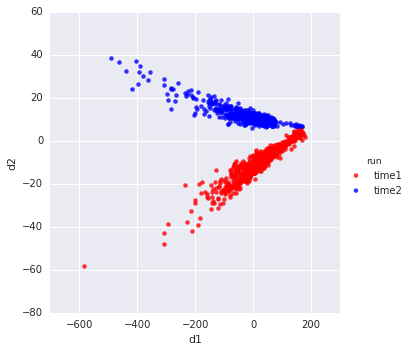

In [661]:
with open(join(topdir,'mESC_trans_time1_rep2','aggregated_counts/full_counts.txt')) as f:
    f.readline()
    data1 = np.asarray([map(float,x.strip().split('\t')[4:]) for x in f]).transpose()
with open(join(topdir,'mESC_trans_time2_rep2','aggregated_counts/full_counts.txt')) as f:
    f.readline()
    data2 = np.asarray([map(float,x.strip().split('\t')[4:]) for x in f]).transpose()

data = np.concatenate((data1/np.sum(data1),data2/np.sum(data2)))
print data.shape
data = mynormalizer(data)

print '### PCA analasis ###'
Y = decomposition.PCA(n_components=2).fit(data).transform(data)
t_data = [[Y[idx][0],Y[idx][1],'time1'] if idx<len(data1) else [Y[idx][0],Y[idx][1],'time2']for idx in range(len(Y))]
d = pd.DataFrame(t_data,columns=['d1','d2','run'])
colors = {'time1':"r", 'time2':"b"}
sns.lmplot("d1", "d2", data=d, hue='run', fit_reg=False,palette=colors)
pylab.show()

##### PCA analysis on time point 1

### PCA analasis ###


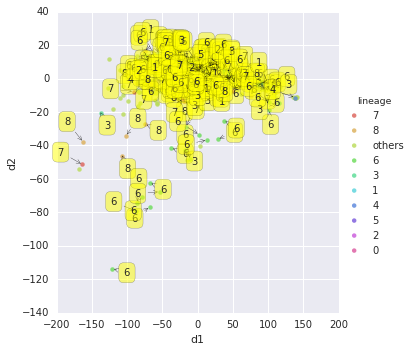

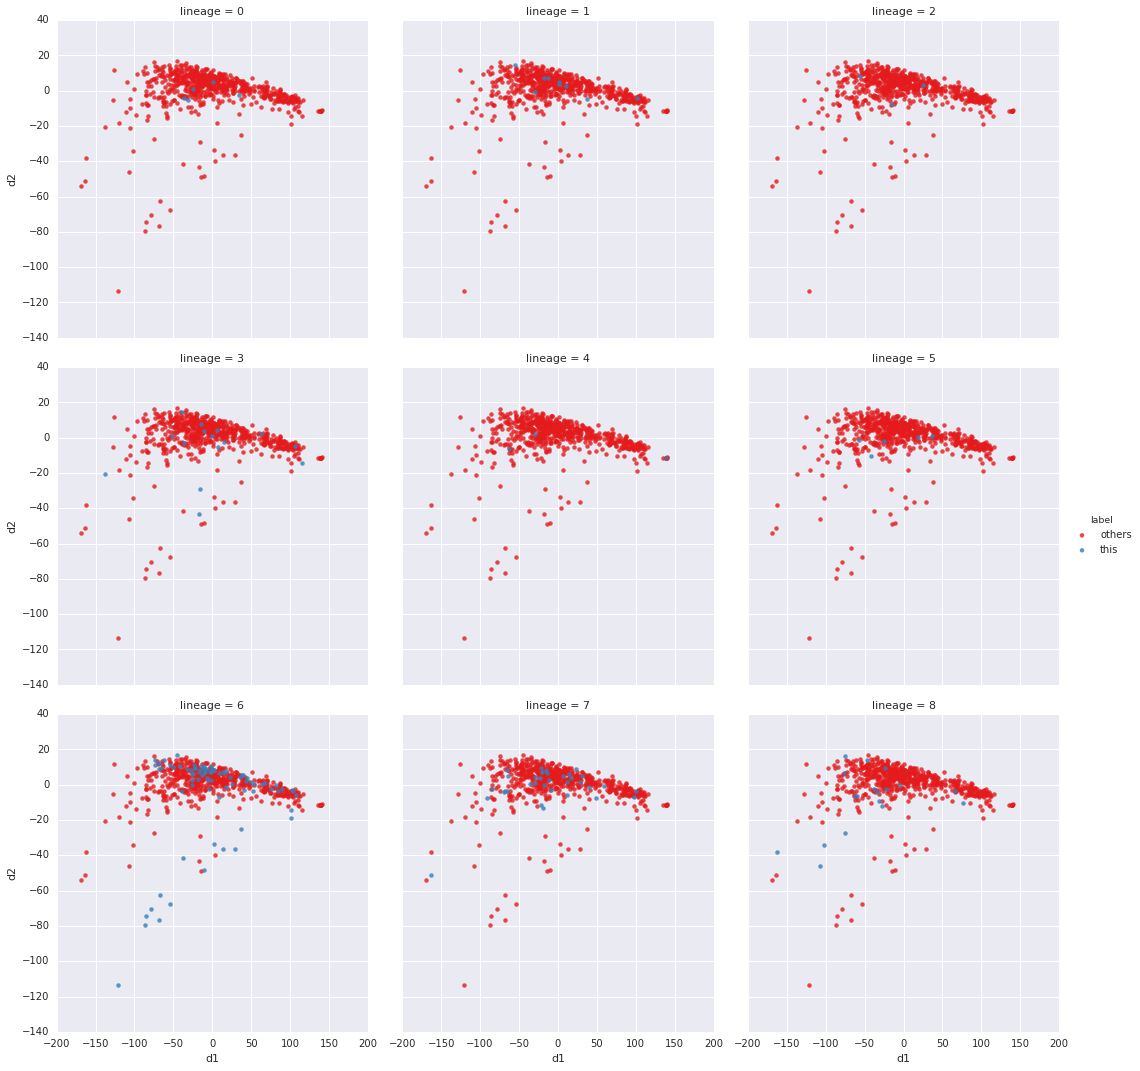

### t-SNE analasis ###


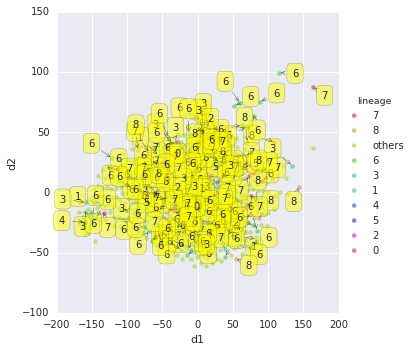

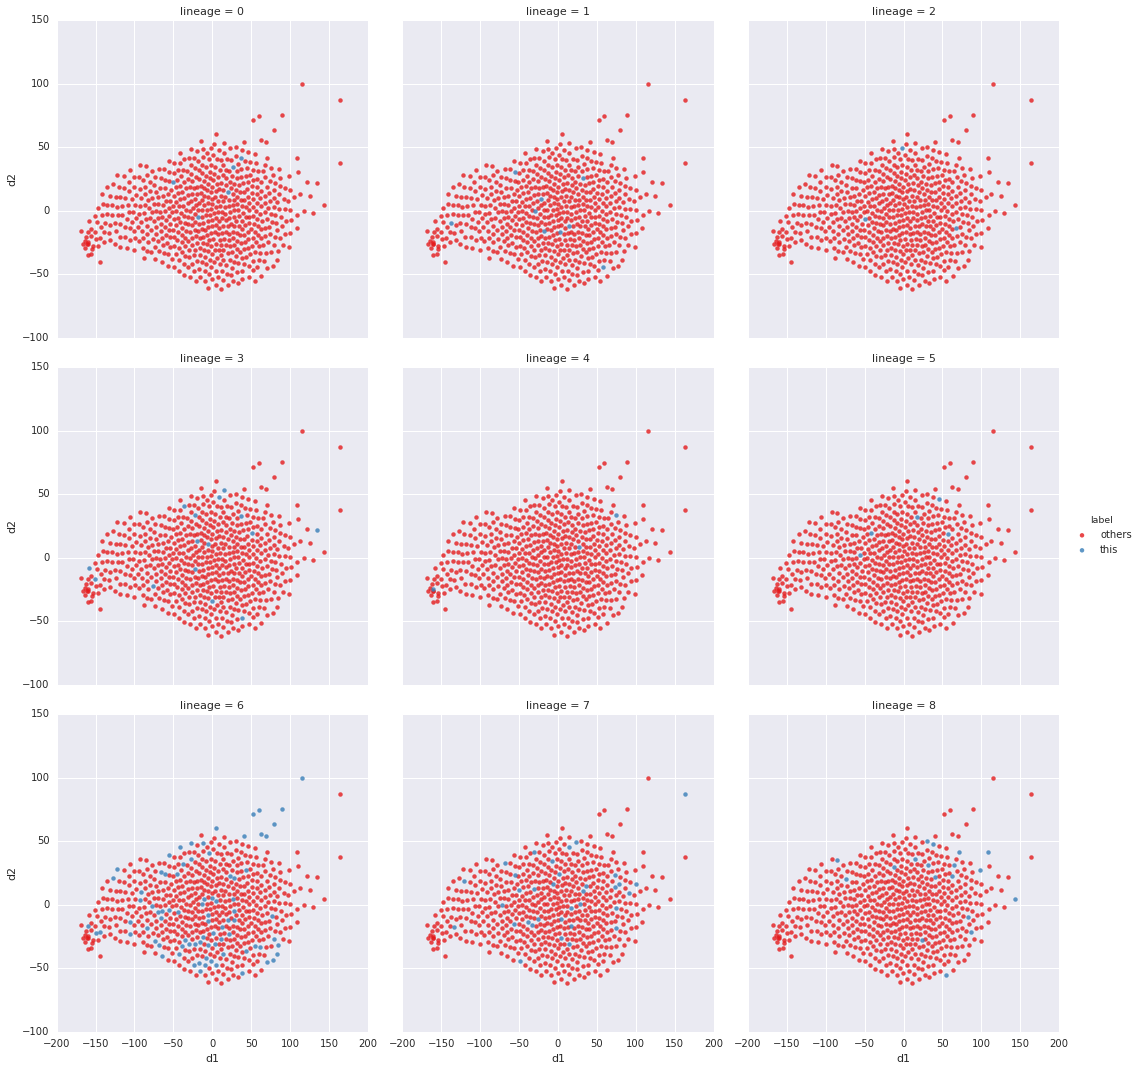

### Isomap analasis ###


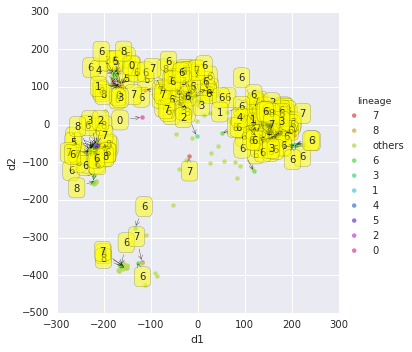

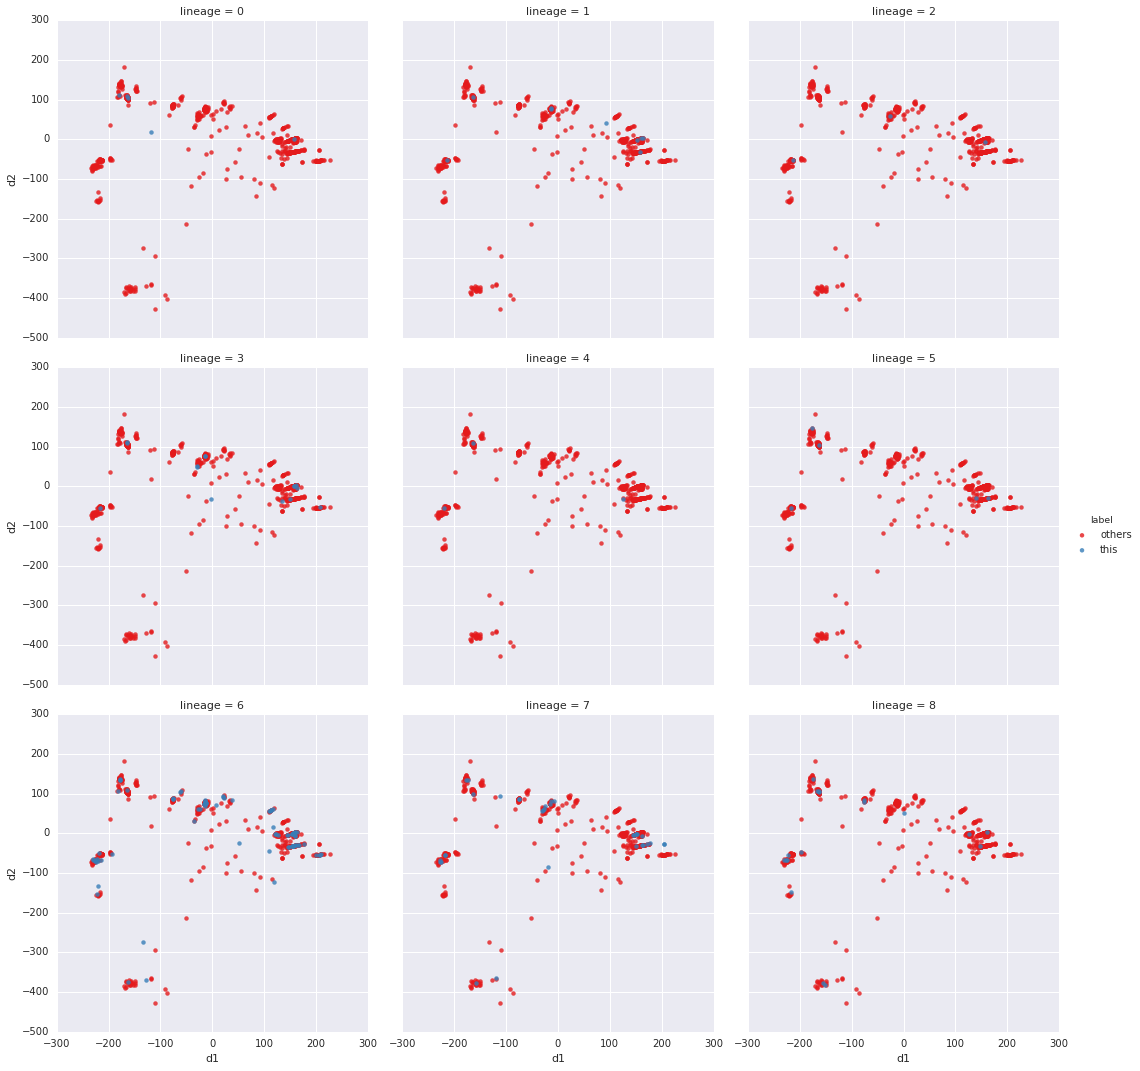

In [662]:
PCAanalysis(expr_data['mESC_trans_time1_rep2'])

##### PCA analysis on time2

### PCA analasis ###


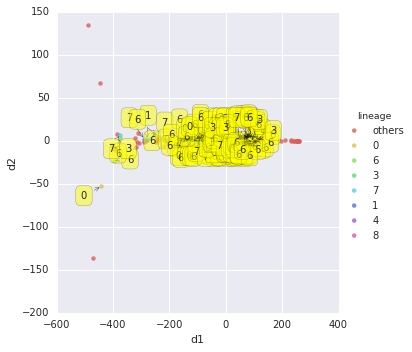

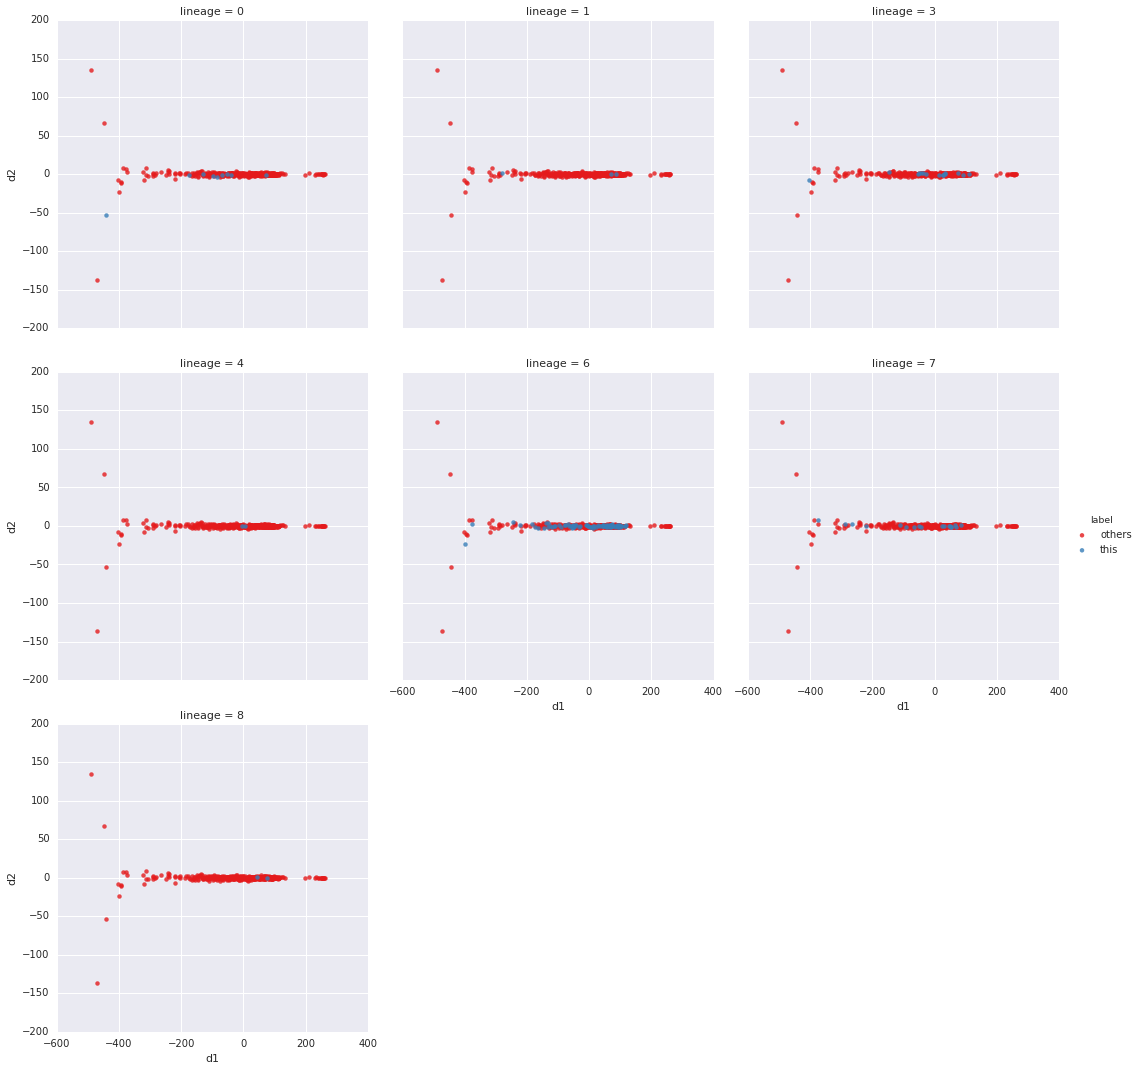

### t-SNE analasis ###


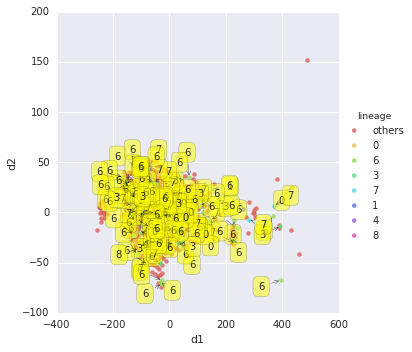

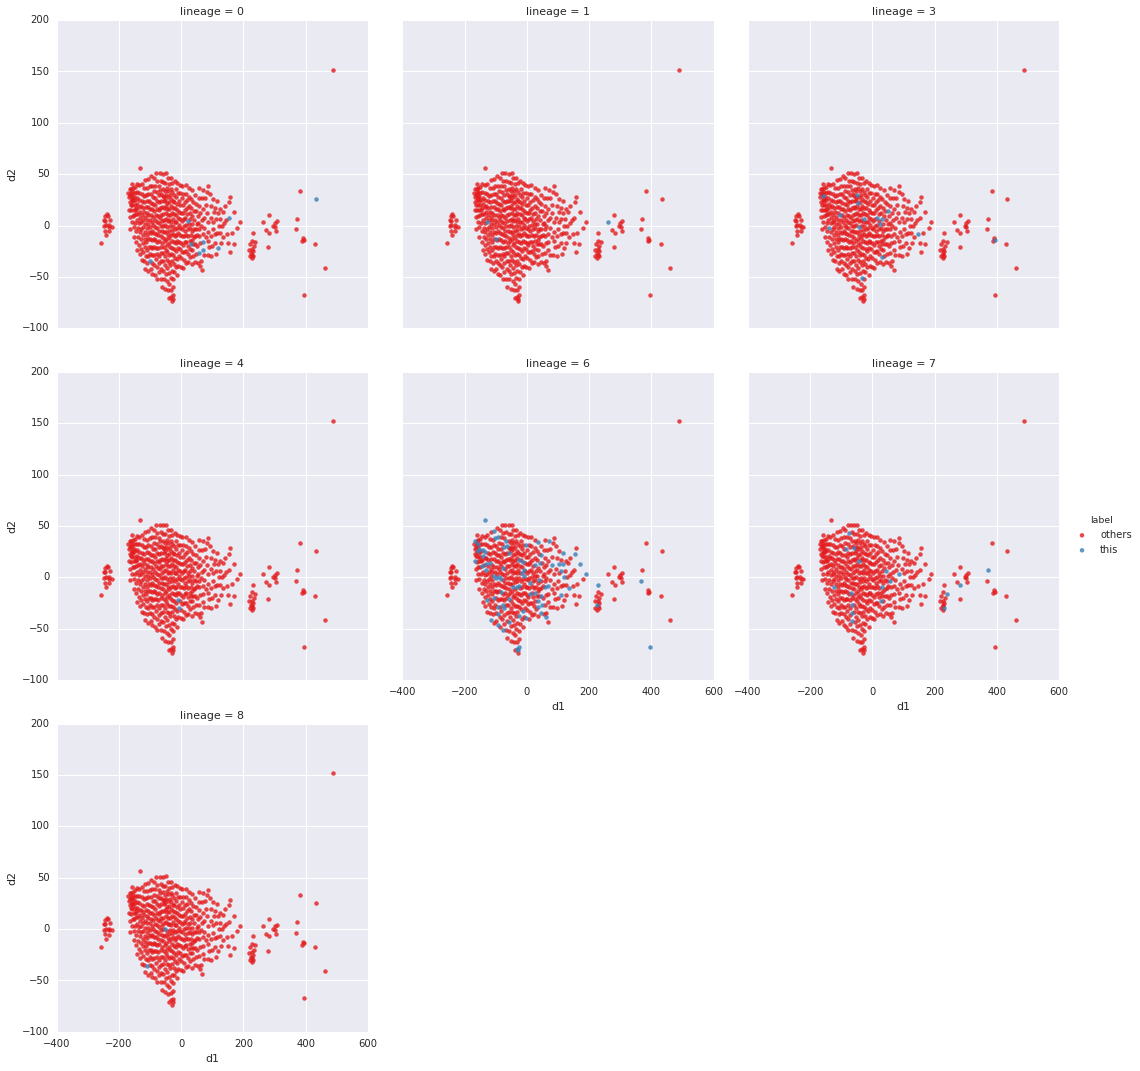

### Isomap analasis ###


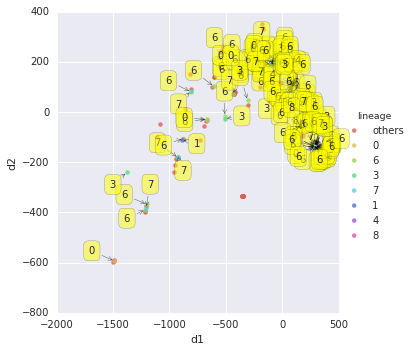

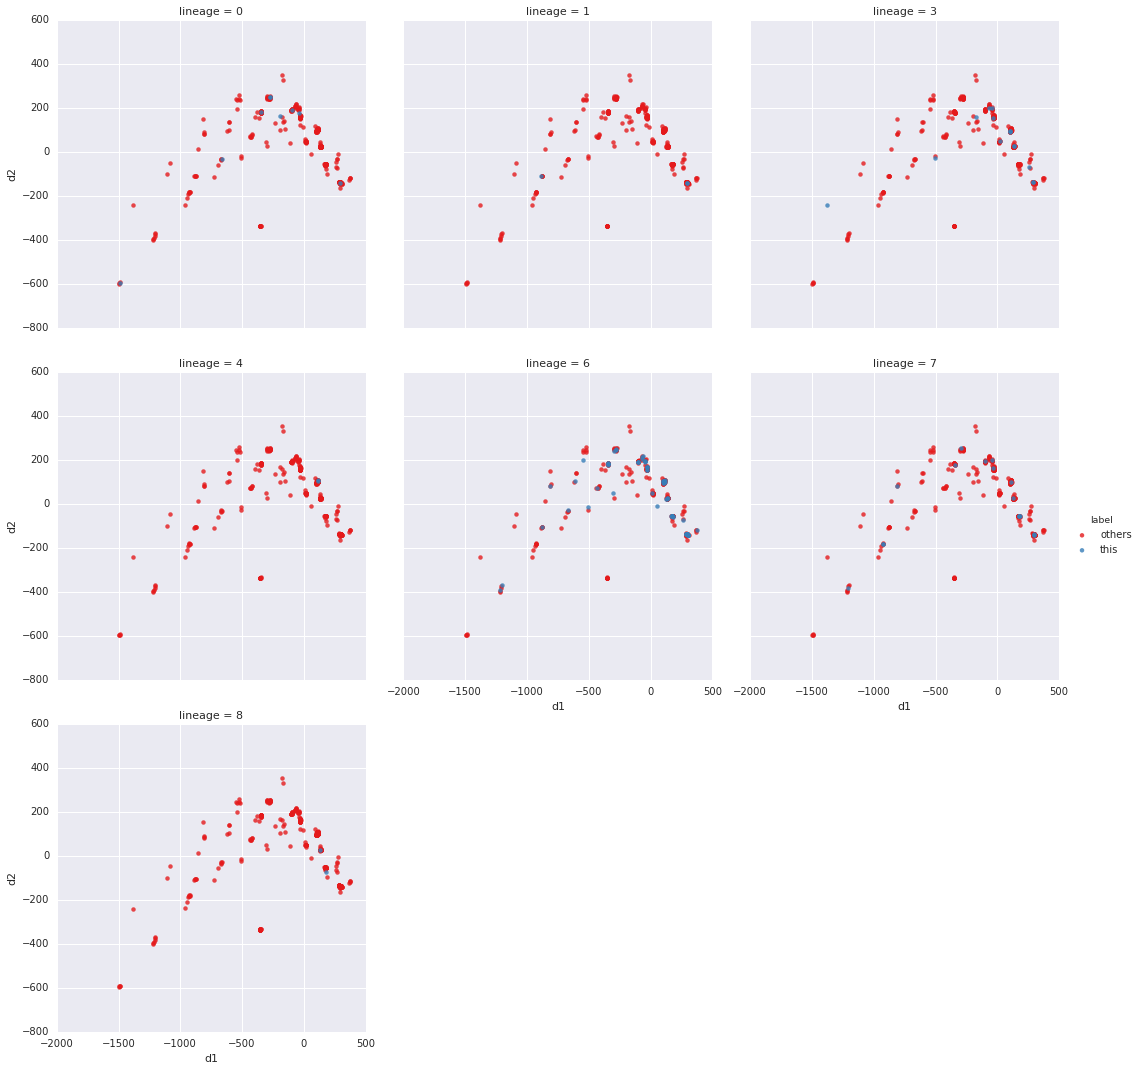

In [663]:
PCAanalysis(expr_data['mESC_trans_time2_rep2'])